In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rc
rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

from tqdm import tqdm, trange, tqdm_notebook
#plt.rcParams["font.family"] = "Times New Roman"
#matplotlib.style.use(["seaborn-notebook", "seaborn-ticks"])

from matplotlib.pylab import get_cmap
import warnings
warnings.filterwarnings('ignore')


import numpy as np
import scipy as sp
import sys, os
import cPickle as pickle
from glob import glob

fs=20
fs_ticks = 16
sys.path.append('/Users/mhuber/PointSource/skylab/')
from SkyMap import SkyMap

from scipy.stats import norm

# define sfb colors
colors = ['#3850A1', '#F79645', '#993A91']
#new trial
colors = ['#0D589A', '#5DB5D0', '#A9DBB7','blue']

from matplotlib.ticker import (AutoMinorLocator, FixedLocator, FuncFormatter,
                               MultipleLocator, NullLocator, LogLocator)
import healpy as hp

from scipy.interpolate import UnivariateSpline
from matplotlib.lines import Line2D


from scipy.interpolate import splrep, splev
from copy import deepcopy 

In [2]:
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from PyAstronomy import pyasl

In [3]:
from astropy import units as u
from astropy.coordinates import SkyCoord

In [12]:
sys.path.append('../')
from core.tools import *
from core.tools import _trans

# Show the declination dependent detection efficiency

first get icecube detection efficieny

<IPython.core.display.Javascript object>


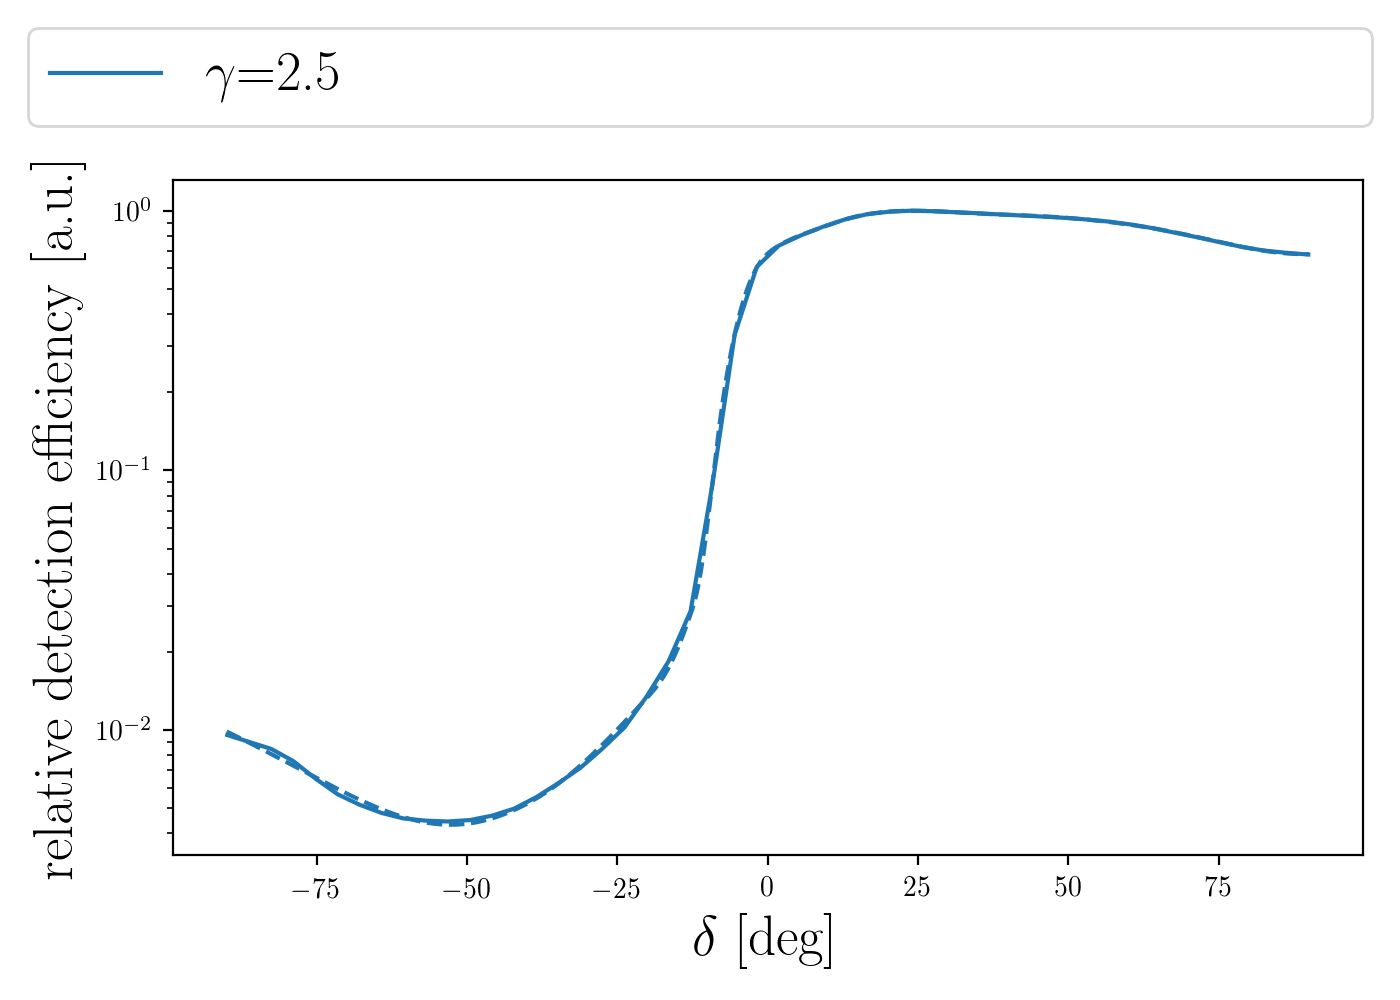

In [5]:
path = "/Users/mhuber/StackingSkylab/MultiYearPointSourceData/"
mc = np.load(os.path.join(path,'IC86-2012_MC.npy'))

ang=4
decs = np.linspace(-np.pi/2+np.radians(0.1), np.pi/2-np.radians(0.1), 50)
xvals = np.linspace(-np.pi/2, np.pi/2, 1000)

fig,ax=plt.subplots(figsize=(7,5))
tcks = dict()
gammas = [2.5]
for gamma in gammas:
    
    Res = np.zeros_like(decs)
    for i, deci in enumerate(decs):
    
        if deci > np.radians(30): ang=10
        dec_min, dec_max = np.sin(deci-np.radians(ang)), np.sin(deci+np.radians(ang))
        Omega = 2 * np.pi * (dec_max - dec_min)
        dec_mask = (np.sin(mc['trueDec']) > dec_min)&(np.sin(mc['trueDec']) < dec_max)

        DetEff = np.sum(mc['ow'][dec_mask] * mc['trueE'][dec_mask]**(-gamma)) / Omega 
        
        


        
        Res[i] = DetEff
    
    Res_max = np.max(Res)
    Res /= np.max(Res)
    
    
    tck = splrep(decs, Res, s=1.e-4)
    spl_val = splev(xvals, tck)
    
    tcks[gamma] = tck
    p=ax.plot(np.degrees(decs), Res, label=r'$\gamma$={0:.1f}'.format(gamma))
    ax.plot(np.degrees(xvals), spl_val, ls='dashed', color=p[0].get_color())
    
fig.legend(loc='upper center', mode='expand', fontsize=fs, ncol=3)
ax.set_xlabel(r'$\delta$ [deg]',fontsize=fs)
ax.set_ylabel(r'relative detection efficiency [a.u.]',fontsize=fs)
ax.set_yscale('log')
fig.tight_layout()

plt.subplots_adjust(top = 0.82)
plt.show()

# Show the discovery potential of Plenum and IceCube in galactic coordinates

In [9]:
NSIDE = 2**6
npix = hp.nside2npix(NSIDE)
ngrid =500

fact = 1.
poles = {'IceCube':(np.radians(0), np.radians(-90.)),
         'Gen2':(np.radians(0), np.radians(-90.)),
         'P-ONE':(-np.radians(123.3656), np.radians(48.4284)),
         'KM3NeT':(np.radians(16.1), np.radians(36.27)) ,
         'Baikal-GVD':(np.radians(108.1650), np.radians(53.5587)),
         #'X, China':(np.radians(111.918), np.radians(8.640)),
         #'SA, Cape Town ':(np.radians(18.4241), np.radians(-33.9249)),
        #'hypothetical':(np.radians(0.2093), np.radians(-0.8688)),
        }
      
comb_values_gal = dict()

    
for i,(name, new_pole) in enumerate(sorted(poles.iteritems())):    
    
    vals = np.zeros(npix)    
    rot_angles = np.arange(0.,360., 30.) #15.
    for rot_ra in tqdm(rot_angles):
        vals2 = np.zeros(npix)
        new_ra = new_pole[0] + np.radians(rot_ra)
        
        x = np.linspace(0,2*np.pi, 1.e3)
        y = np.linspace(-np.pi/2,np.pi/2 ,500)
    
        xx, yy = np.meshgrid(x,y,indexing='ij')
        
        ra2 , dec2 = rotate(0, -np.pi/2, new_ra, new_pole[1],xx.ravel(),yy.ravel())
        
        
        cords = SkyCoord(ra2, dec2,  unit='rad')#frame='icrs',
        
        lg = cords.galactic.l.rad
        bg = cords.galactic.b.rad
        #print(np.min(lg), np.max(lg))
        #print(np.min(bg), np.max(bg))
        
        lat2 = np.pi/2 + bg
        mask_lon = lg > np.pi
        lg[mask_lon] = np.mod(lg[mask_lon], np.pi) - np.pi
        lon2 = lg
        
        #print(np.min(lon2), np.max(lon2))
        #print(np.min(lat2), np.max(lat2))
        
        
        p = hp.ang2pix(NSIDE, lat2, lon2)
        
        if name == 'IceCube' or 'Gen2' in name:
            vals2[p] = splev(yy.ravel(), tck)
        else:
            vals2[p] = splev(yy.ravel(), tck) 
        
        if name == 'Gen2':
            vals2 *= 7.5
    
        vals = vals + vals2 * (1. / len(rot_angles))
    
    comb_values_gal[name] = vals
    
blub = 5000

100%|██████████| 12/12 [00:15<00:00,  1.29s/it]


<IPython.core.display.Javascript object>


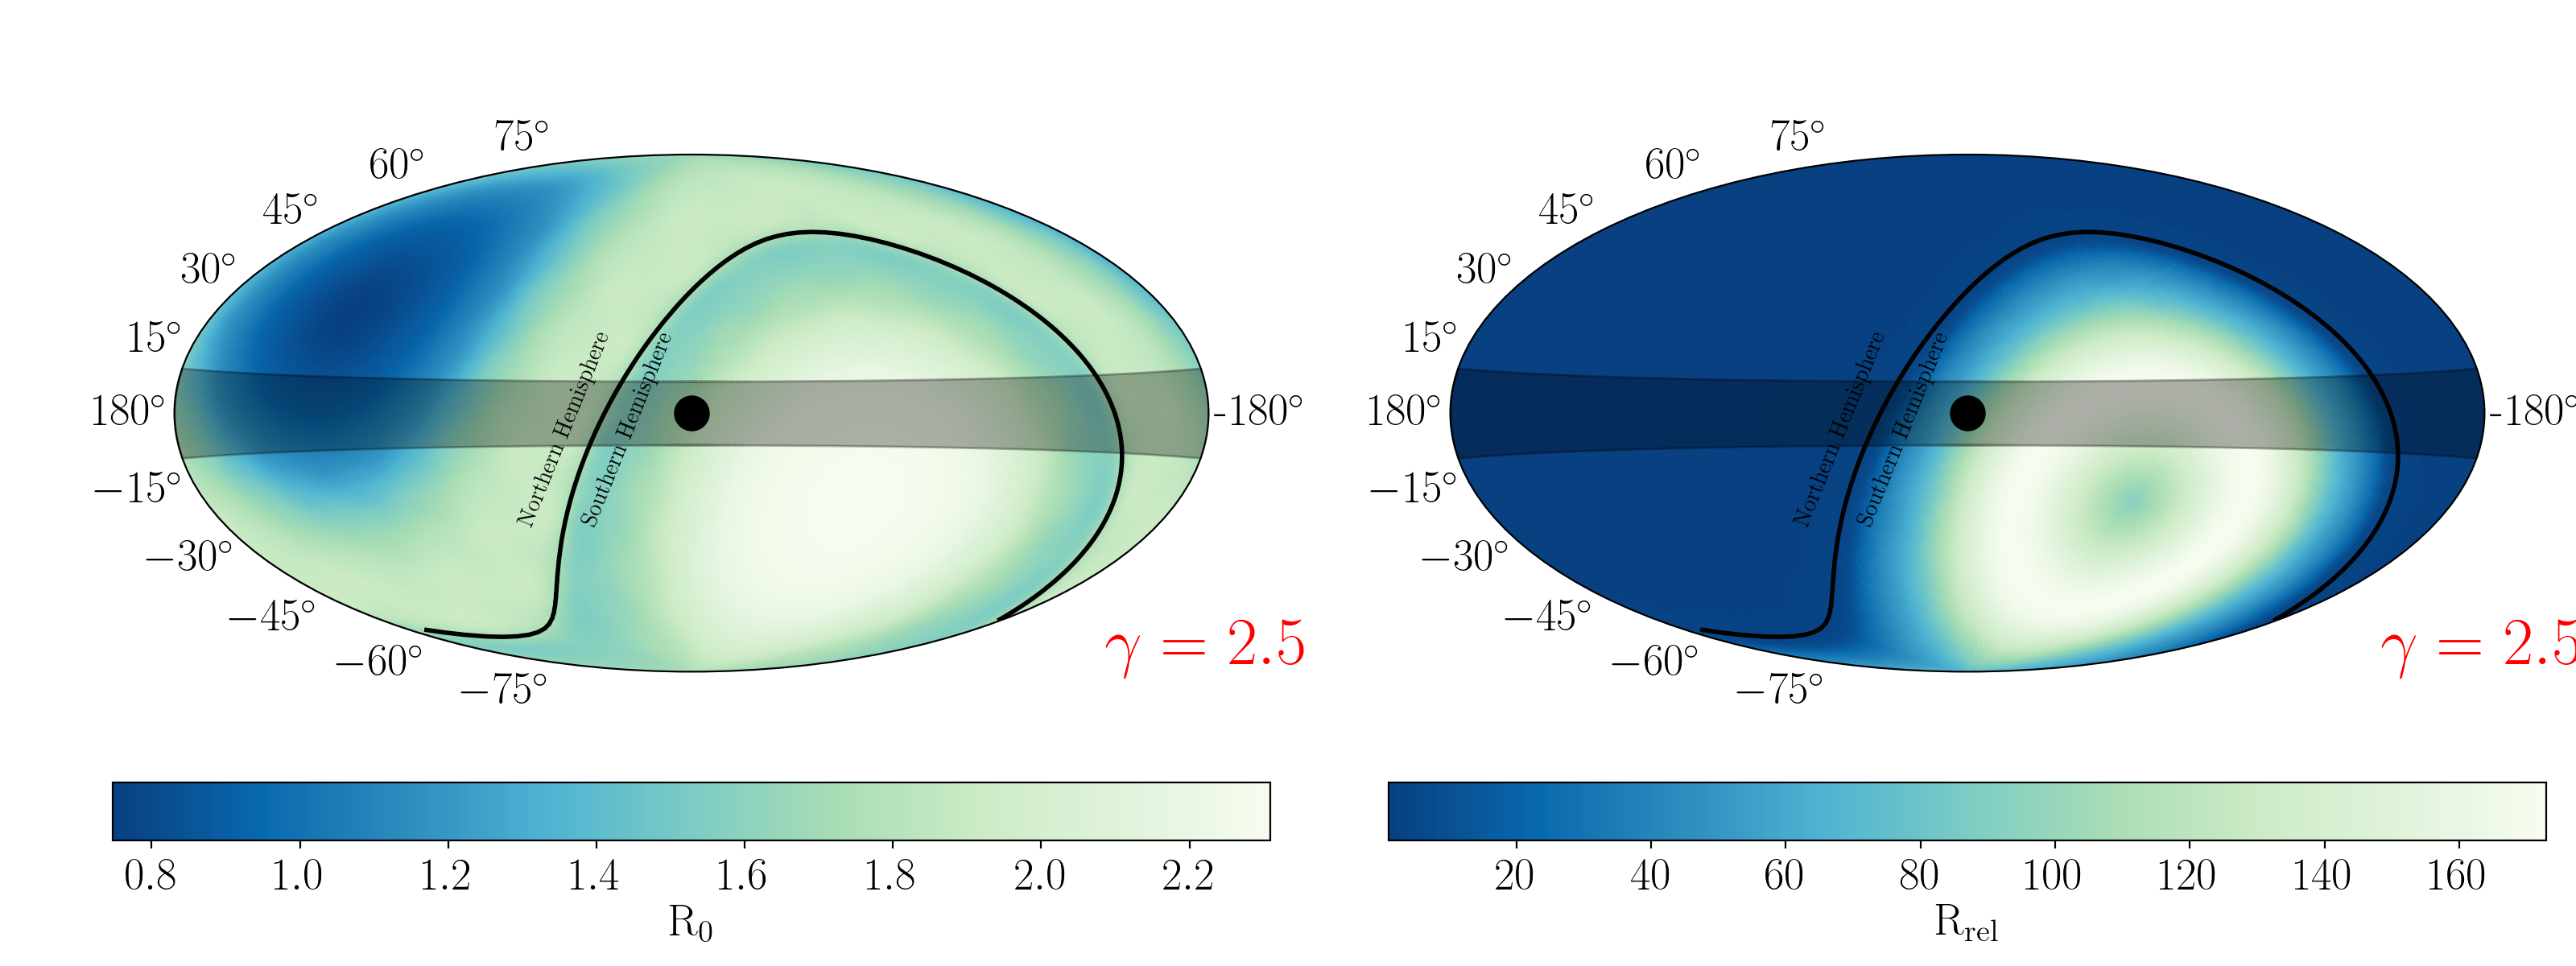

0.7473296456967988
2.3089776391182317
1.0171979286599944
172.92495766588712


In [15]:
t_0 = 0. # years
t_new = 1. # years

used_keys = list()
fact = 1.

fig =  plt.figure(figsize=(16,6))
    
bckg_vals2 = deepcopy(comb_values_gal['IceCube'])
all_vals = deepcopy(comb_values_gal)


i2ind = {0:121, 1:122}

variation = ['r0', 'rrel']
labels = {'r0': r'R$_0$', 'rrel':r'R$_{\mathrm{rel}}$'}
extreme = {'r0': (0.7,2.2), 'rrel':(2,25.)}
for i, vari in enumerate(variation):
    
    comb_vals = np.zeros(npix)
    ax= fig.add_subplot(i2ind[i], projection='hammer',
                                       rasterized=True)
    
    for (name, vali) in sorted(all_vals.iteritems()):
        if vari == 'rrel':
            mask_bckg = bckg_vals2 > 0.0
            vali[mask_bckg] /= bckg_vals2[mask_bckg]
            vali[~mask_bckg] = np.max(vali[mask_bckg])
            
    
        nuse = [ 'Gen2', 'X, China',#'P-ONE','KM3NeT'
                         ]
        

        if name == 'IceCube' and 'Gen2' in nuse:
            comb_vals += (t_0+t_new) * vali
        elif name == 'IceCube':
            comb_vals += t_0 * vali
        elif name in nuse:
            continue
        else:
            comb_vals += t_new * vali * fact

        if name not in used_keys:
            used_keys.append(name)

    new_vals = (comb_vals / (t_0+t_new))**(-0.8)
    mask0 = new_vals > 0.
    new_vals[mask0] = 1. / new_vals[mask0]
    new_vals[~mask0] = 0.

    print(np.min(new_vals))

    #
    #
    _min,_max = extreme[vari]
    _min = np.min(new_vals)
    _max = np.max(new_vals)
    
    print(_max)

    cax=plot_area(new_vals, ax, npix=ngrid,  alpha=1., vmax=_max,  vmin=_min, #.e14, #vmax=1.,
             shading='gouraud', cmap='GnBu_r', galactic=True)# norm=LogNorm())

    cbar = fig.colorbar(cax,  orientation='horizontal')
    cbar.ax.tick_params(labelsize=fs)
    cbar.set_label(labels[vari], 
                   fontsize=fs)

    
    

    cords = SkyCoord(np.linspace(0,2*np.pi,100), np.ones(100)*np.deg2rad(-5.),  frame='icrs',
                     unit='rad')
    
    lrad = cords.galactic.l.rad
    mask_l = lrad > np.pi
    lrad[mask_l] = np.mod(lrad[mask_l], np.pi) - np.pi
    
    ltot = np.append(-lrad[12:], -lrad[:11])
    btot = np.append(cords.galactic.b.rad[12:], cords.galactic.b.rad[:11])
    ax.plot(ltot, btot, marker='None', ls='solid' ,lw=2, color='black')
    
    
    ax.plot(0,0,marker='o', color='black', markersize=15)
    x = np.linspace(-np.pi, np.pi, 100)
    ax.fill_between(x, np.ones_like(x)*np.deg2rad(-10), np.ones_like(x)*np.deg2rad(10), 
                    alpha=0.3, color='black')
    
    #-------------------------------
    # fix the labels
    #-------------------------------

    set_ticks(ax, fs=fs, galactic=True)
    ax.annotate('Northern Hemisphere', xy=(-np.deg2rad(40),np.deg2rad(-5.)), 
                ha='center', va='center', rotation=68.)

    
    ax.annotate('Southern Hemisphere', xy=(-np.deg2rad(20),np.deg2rad(-5.)), 
                ha='center', va='center', rotation=68.)
    
    
    #---------------------------------------
    # add the galactic center and plane
    #---------------------------------------


    ax.text(.9, .01, r"$\gamma=2.5$", ha='left', size=fs+10, transform=ax.transAxes,
           color='red')
    

fig.legend(fontsize=fs+4, loc='upper center', ncol=4, frameon=False,  mode='expand')
fig.tight_layout()

plt.subplots_adjust(top = 0.84)#, bottom=0.2)

#fig.savefig('/Users/mhuber/Documents/Papers/Plenum/Plenum_g25_galactic.png',
#                bbox_inches="tight", dpi=200)